In [1]:
"""demo: how to use dndlstm"""

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import time

from NN.DNDLSTM import DNDLSTM

%matplotlib inline 
%autosave 5

sns.set(style='white', context='talk', font_scale=.9, rc={"lines.linewidth": 2.5})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

Autosaving every 5 seconds


In [2]:
# set params
dim_input = 1
dim_hidden = 20
dim_output = dim_input
# layer_norm = False
# dnd 
dict_len = 60
kernel = 'cosine'
learning_rate = 1e-4
# train params
n_epochs = 100
n_time_steps = 60

# gen data
x_np = np.sin(np.linspace(0, 8*np.pi, n_time_steps))
x_np = np.reshape(x_np, newshape=(n_time_steps, 1, 1))
x = torch.from_numpy(x_np).type(torch.FloatTensor)

In [3]:
# init model and hidden state.
lstm = DNDLSTM(dim_input, dim_hidden, dict_len, kernel)
# lstm.dnd.retrieval_off = True
# lstm.dnd.encoding_off = True
readout = nn.Linear(dim_hidden, dim_output)
# 
h_0 = torch.zeros(1, 1, dim_hidden)
c_0 = torch.zeros(1, 1, dim_hidden)
# h_0 = torch.randn(1, 1, dim_hidden)
# c_0 = torch.randn(1, 1, dim_hidden)
# init optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(lstm.parameters())+list(readout.parameters()), 
    lr=learning_rate
)

In [4]:
# train the model 
clip_grad_norm_val = .5

losses = np.zeros(n_epochs,)
c_norm_cache = np.zeros((n_epochs,n_time_steps))
h_norm_cache = np.zeros((n_epochs,n_time_steps))

# loop over epoch
for i in range(n_epochs):
    time_start = time.time()

    # loop over time, for one training example
    for t, x_t in enumerate(x):
        # init rnn states
        if t == 0:
            h_t = h_0 
            c_t = c_0 

        # recurrent computation at time t
        out, h_t, c_t, _ = lstm(
            x_t.view(1, 1, -1), h_t, c_t)
        out = readout(out)
        # compute loss
        out_sqed = torch.squeeze(out, dim=0)
        loss = criterion(out_sqed, x_t)
        losses[i] += loss.item()

        # update weights
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(lstm.parameters(), clip_grad_norm_val)
        optimizer.step()
        
        # fetch some info 
        c_norm_cache[i,t] = np.linalg.norm(c_t.data)
        h_norm_cache[i,t] = np.linalg.norm(h_t.data)

    # print out some stuff
    time_end = time.time()
    print(f'Epoch {i} | \t loss = {losses[i]}, \t time = {time_end - time_start}')

Epoch 0 | 	 loss = 33.78444240568206, 	 time = 0.41687607765197754
Epoch 1 | 	 loss = 34.87916831043549, 	 time = 0.4161238670349121
Epoch 2 | 	 loss = 34.172004281776026, 	 time = 0.40338873863220215
Epoch 3 | 	 loss = 33.329357616836205, 	 time = 0.3985331058502197
Epoch 4 | 	 loss = 32.28031919640489, 	 time = 0.3932301998138428
Epoch 5 | 	 loss = 31.36168303032173, 	 time = 0.39878106117248535
Epoch 6 | 	 loss = 30.72402083234465, 	 time = 0.4212980270385742
Epoch 7 | 	 loss = 30.028482510666436, 	 time = 0.43766307830810547
Epoch 8 | 	 loss = 29.269174840782398, 	 time = 0.41246795654296875
Epoch 9 | 	 loss = 28.65215518805053, 	 time = 0.4054281711578369
Epoch 10 | 	 loss = 27.939061328739626, 	 time = 0.4062540531158447
Epoch 11 | 	 loss = 27.23895536380587, 	 time = 0.42655277252197266
Epoch 12 | 	 loss = 26.540129971690476, 	 time = 0.4102001190185547
Epoch 13 | 	 loss = 25.826866876566783, 	 time = 0.39807796478271484
Epoch 14 | 	 loss = 25.460090264794417, 	 time = 0.4317800

Text(0, 0.5, 'MSE')

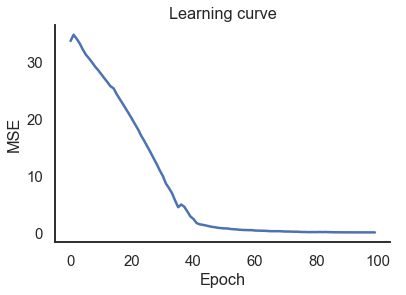

In [5]:
plt.plot(losses)
sns.despine()
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')

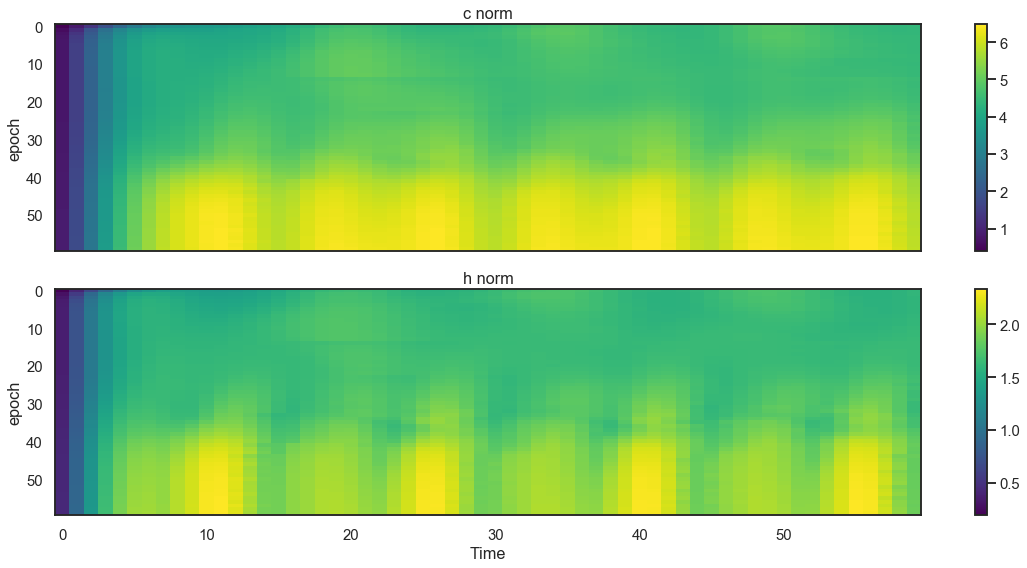

In [6]:
f,axes = plt.subplots(2,1, figsize=(16,8), sharex=True)
# im_plot = np.log(h_norm_cache[:, :])
t_plt = n_time_steps
epoch_plt = n_epochs
ims_plt = [c_norm_cache[:t_plt, :epoch_plt], h_norm_cache[:t_plt, :epoch_plt]]
titles_plt = ['c norm', 'h norm']
ims = [None] * 2

for i in range(2): 
    ims[i] = axes[i].imshow(ims_plt[i], cmap='viridis', aspect='auto')
    axes[i].set_title(titles_plt[i])
    axes[i].set_ylabel('epoch')
    f.colorbar(ims[i], ax=axes[i])
    
axes[-1].set_xlabel('Time')    
f.tight_layout()

In [10]:
# test the model: fit and extrapolation 
n_time_steps_extrapolate = n_time_steps

f_t = [None] * (n_time_steps + n_time_steps_extrapolate)
i_t = [None] * (n_time_steps + n_time_steps_extrapolate)
o_t = [None] * (n_time_steps + n_time_steps_extrapolate)
r_t = [None] * (n_time_steps + n_time_steps_extrapolate)
m_t = [None] * (n_time_steps + n_time_steps_extrapolate)
x_hat = [None] * (n_time_steps + n_time_steps_extrapolate)

with torch.no_grad():
    # on the training support
    lstm.encoding_off = False
    for t, x_t in enumerate(x):
        if t == 0:
            h_t = h_0 
            c_t = c_0 
        out, h_t, c_t, cache = lstm(x_t.view(1, 1, -1), h_t, c_t)
        out = readout(out)
        x_hat[t] = out.data
        f_t[t], i_t[t], o_t[t], r_t[t], m_t[t] = cache
    lstm.encoding_off = True
    
    # extrapolation
    for t in range(n_time_steps_extrapolate):
        out, h_t, c_t, cache = lstm(out, h_t, c_t)
        out = readout(out)
        x_hat[n_time_steps+t] = out.data
        
        f_t[n_time_steps+t], i_t[n_time_steps+t], \
        o_t[n_time_steps+t], r_t[n_time_steps+t], \
        m_t[n_time_steps+t] = cache

Text(0.5, 0, 'x / time')

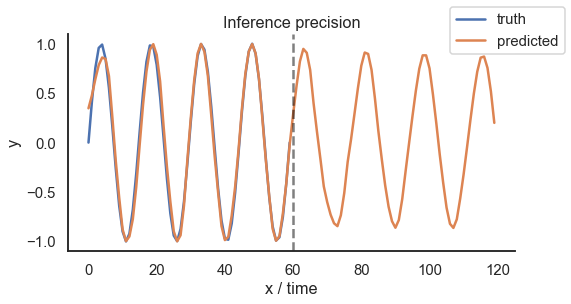

In [11]:
# plot it
f, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(x.numpy()), label='truth')
ax.plot(np.squeeze(x_hat), label='predicted')
ax.axvline(n_time_steps, alpha=.5, linestyle='--', color='black')
f.legend()
sns.despine()
ax.set_title('Inference precision')
ax.set_ylabel('y')
ax.set_xlabel('x / time')

Text(0.5, 0, 'x / time')

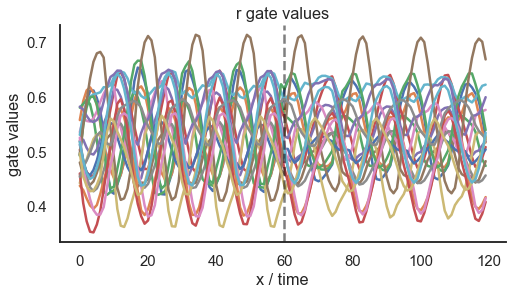

In [12]:
gate_vals = r_t
temp = np.squeeze([gate_vals[t].data.numpy() for t in range(len(r_t))])

f, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(temp)
ax.axvline(n_time_steps, alpha=.5, linestyle='--', color='black')
sns.despine()
ax.set_title('r gate values')
ax.set_ylabel('gate values')
ax.set_xlabel('x / time')

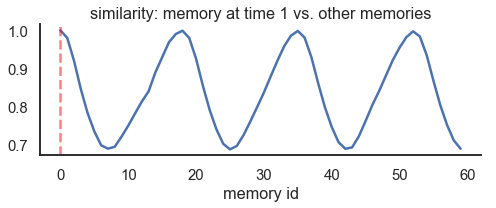

In [13]:
from NN.DND import compute_similarities

tempt = 0
q = lstm.dnd.vals[tempt]
ds = [
    compute_similarities(q, [lstm.dnd.vals[i]], lstm.dnd.kernel).item()
    for i in range(len(lstm.dnd.vals))
]
f, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(ds)
ax.axvline(tempt, alpha=.5, linestyle='--', color='red')
sns.despine()
ax.set_xlabel('memory id')
ax.set_title(f'similarity: memory at time {tempt+1} vs. other memories')
f.tight_layout()

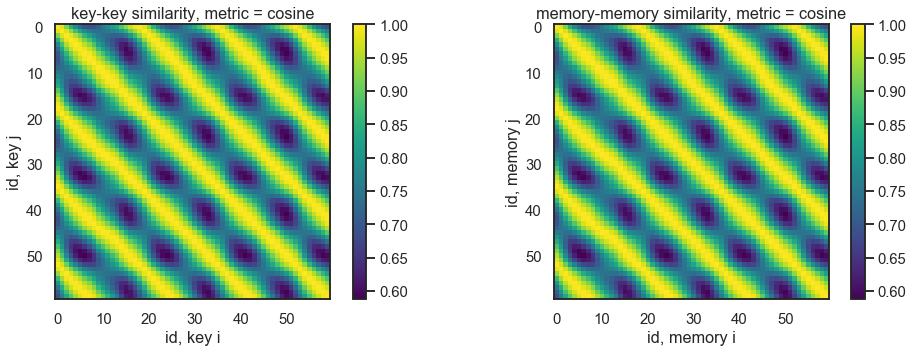

In [14]:
from NN.DND import compute_similarities

dmat_mm = np.zeros((dict_len,dict_len))
dmat_kk = np.zeros((dict_len,dict_len))
for i in range(dict_len): 
    for j in range(dict_len): 
        dmat_mm[i,j] = compute_similarities(lstm.dnd.vals[i], [lstm.dnd.vals[j]], lstm.dnd.kernel).item()
        dmat_kk[i,j] = compute_similarities(lstm.dnd.keys[i], [lstm.dnd.keys[j]], lstm.dnd.kernel).item()

# plot 
dmats = [dmat_kk, dmat_mm]        
labels = ['key', 'memory']

f, axes = plt.subplots(1, 2, figsize = (14,5))
for i, ax in enumerate(axes): 

    im = ax.imshow(dmats[i], cmap='viridis')
    f.colorbar(im, ax=ax)
    
    ax.set_xlabel(f'id, {labels[i]} i')
    ax.set_ylabel(f'id, {labels[i]} j')
    ax.set_title(f'{labels[i]}-{labels[i]} similarity, metric = {lstm.dnd.kernel}')

f.tight_layout()